# 1. Setup & Data Preparation
Loading CIFAR-10 dataset with standard augmentation (RandomCrop, Flip) and normalization.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import os

# 1. تنظیمات سخت‌افزار
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. ساخت پوشه‌های خروجی
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/models', exist_ok=True)

# 3. تنظیمات پیش‌پردازش استاندارد CIFAR-10
# اعداد دقیق میانگین و انحراف معیار
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

# تبدیل‌های داده‌های آموزشی (Augmentation استاندارد)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # برش تصادفی
    transforms.RandomHorizontalFlip(),    # چرخش افقی
    transforms.ToTensor(),
    transforms.Normalize(mean, std),      # نرمال‌سازی
])

# تبدیل‌های داده‌های تست (فقط نرمال‌سازی)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 4. دانلود و بارگذاری دیتاست
print("Loading CIFAR-10 Dataset...")
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
full_val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

# ---------------------------------------------------------
# تنظیمات سایز دیتاست (Full vs Fast)
#
train_dataset = full_train_dataset
val_dataset = full_val_dataset
BATCH_SIZE = 128 # برای دیتای زیاد، بچ سایز بزرگتر بهتر است

# ---------------------------------------------------------

# 5. ساخت دیتالودرها
# num_workers=0 برای جلوگیری از ارور در ویندوز
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("-" * 50)
print(f"Data Setup Complete!")
print(f"Training Images: {len(train_dataset)}")
print(f"Validation Images: {len(val_dataset)}")
print(f"Batch Size: {BATCH_SIZE}")
print("-" * 50)

Using device: cuda
Loading CIFAR-10 Dataset...


100%|██████████| 170M/170M [00:05<00:00, 31.2MB/s]


--------------------------------------------------
Data Setup Complete!
Training Images: 50000
Validation Images: 10000
Batch Size: 128
--------------------------------------------------


# 2. Model Architecture (StrongerCNN)
Defining a custom 8-layer VGG-style CNN with Batch Normalization and Dropout.

In [ ]:
import torch.nn as nn

class StrongerCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Block 1: یادگیری ویژگی‌های خیلی ابتدایی (لبه‌ها)
        # 32x32 -> 32x32 -> 16x16
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), # لایه اضافه شده
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Block 2: یادگیری بافت‌ها
        # 16x16 -> 16x16 -> 8x8
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), # لایه اضافه شده
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Block 3: یادگیری اجزای اشیاء
        # 8x8 -> 8x8 -> 4x4
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), # لایه اضافه شده
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Block 4: یادگیری مفاهیم کلی
        # 4x4 -> 4x4 -> 2x2
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1), # افزایش عمق به 512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), # لایه اضافه شده
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.4), # دراپ‌اوت کمی بیشتر چون مدل بزرگتر شد
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

model = StrongerCNN().to(device)
print("StrongerCNN (8 Layers) created successfully.")

StrongerCNN (8 Layers) created successfully.


# 3. Training Loop
Training for 50 epochs using **SGD Optimizer** and **Cosine Annealing Scheduler**.

In [ ]:
import torch.optim as optim
import time

# تنظیمات هایپرپارامترها
num_epochs = 50          # تعداد دورها
initial_lr = 0.1          # نرخ یادگیری اولیه

# تعریف تابع هزینه
criterion = nn.CrossEntropyLoss()

# تعریف Optimizer: SGD با Momentum و Weight Decay
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)

# تعریف Scheduler: کاهش نرخ یادگیری به صورت کسینوسی
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# لیست‌ها برای ذخیره نتایج
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_acc = 0.0

print(f"Starting Training on {device} using SGD + Cosine Annealing...")
start_time = time.time()

for epoch in range(num_epochs):
    # --------------------
    # 1. Train
    # --------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # --------------------
    # 2. Validation
    # --------------------
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * labels.size(0)
            predicted = outputs.argmax(dim=1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / val_total
    epoch_val_acc = 100 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    # آپدیت نرخ یادگیری
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    # --- تغییر: چاپ Loss در کنار Accuracy ---
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.4f} | "
          f"Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
          f"Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

    # ذخیره بهترین مدل
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), 'outputs/models/best_model.pth')

total_time = time.time() - start_time
print(f"Training Finished in {total_time:.0f}s. Best Accuracy: {best_acc:.2f}%")

Starting Training on cuda using SGD + Cosine Annealing...
Epoch 1/50 | LR: 0.1000 | Loss: 1.6513 | Val Loss: 1.4390 | Acc: 39.38% | Val Acc: 50.60%
Epoch 2/50 | LR: 0.0999 | Loss: 1.1879 | Val Loss: 2.0894 | Acc: 58.30% | Val Acc: 42.26%
Epoch 3/50 | LR: 0.0996 | Loss: 0.9137 | Val Loss: 1.2357 | Acc: 68.58% | Val Acc: 57.95%
Epoch 4/50 | LR: 0.0991 | Loss: 0.7660 | Val Loss: 0.8072 | Acc: 74.08% | Val Acc: 72.50%
Epoch 5/50 | LR: 0.0984 | Loss: 0.6867 | Val Loss: 0.7938 | Acc: 76.91% | Val Acc: 73.76%
Epoch 6/50 | LR: 0.0976 | Loss: 0.6282 | Val Loss: 0.8751 | Acc: 79.05% | Val Acc: 70.46%
Epoch 7/50 | LR: 0.0965 | Loss: 0.5843 | Val Loss: 0.7994 | Acc: 80.47% | Val Acc: 72.76%
Epoch 8/50 | LR: 0.0952 | Loss: 0.5590 | Val Loss: 0.6481 | Acc: 81.55% | Val Acc: 77.69%
Epoch 9/50 | LR: 0.0938 | Loss: 0.5352 | Val Loss: 0.7267 | Acc: 82.10% | Val Acc: 76.06%
Epoch 10/50 | LR: 0.0922 | Loss: 0.5113 | Val Loss: 0.5506 | Acc: 82.93% | Val Acc: 81.84%
Epoch 11/50 | LR: 0.0905 | Loss: 0.4829 |

# 4. Performance Plots
Visualizing Train/Validation Loss and Accuracy trends to check for convergence.

Plots saved.


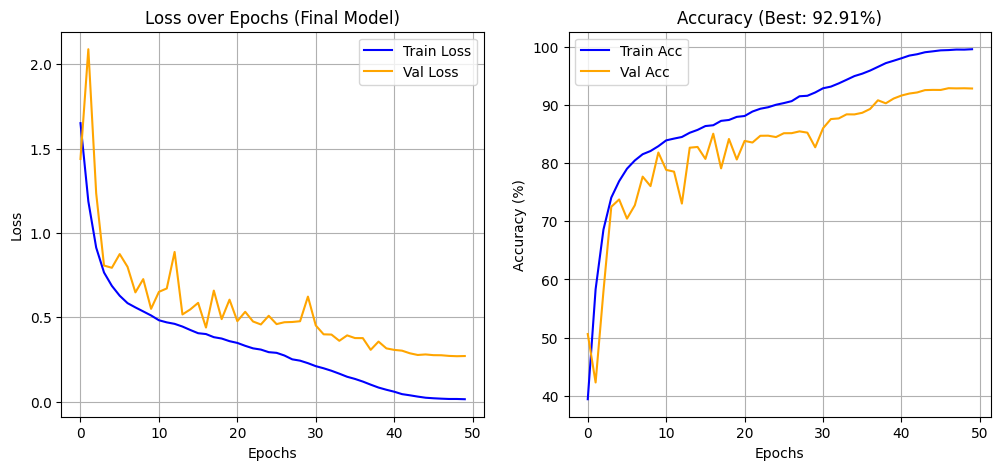

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# نمودار Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.title('Loss over Epochs (Final Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# نمودار Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', color='blue')
plt.plot(val_accs, label='Val Acc', color='orange')
plt.title('Accuracy (Best: 92.91%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.savefig('outputs/figures/final_training_plot.png')
print("Plots saved.")
plt.show()

# 5. Feature Map Visualization
Inspecting internal features extracted by the model at 4 different depths (Layers).

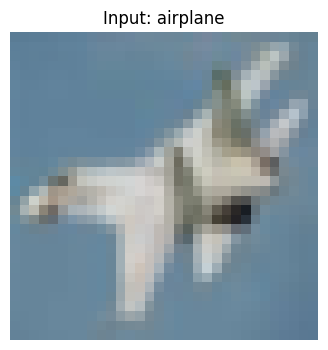

Found 8 Convolutional Layers in the model.


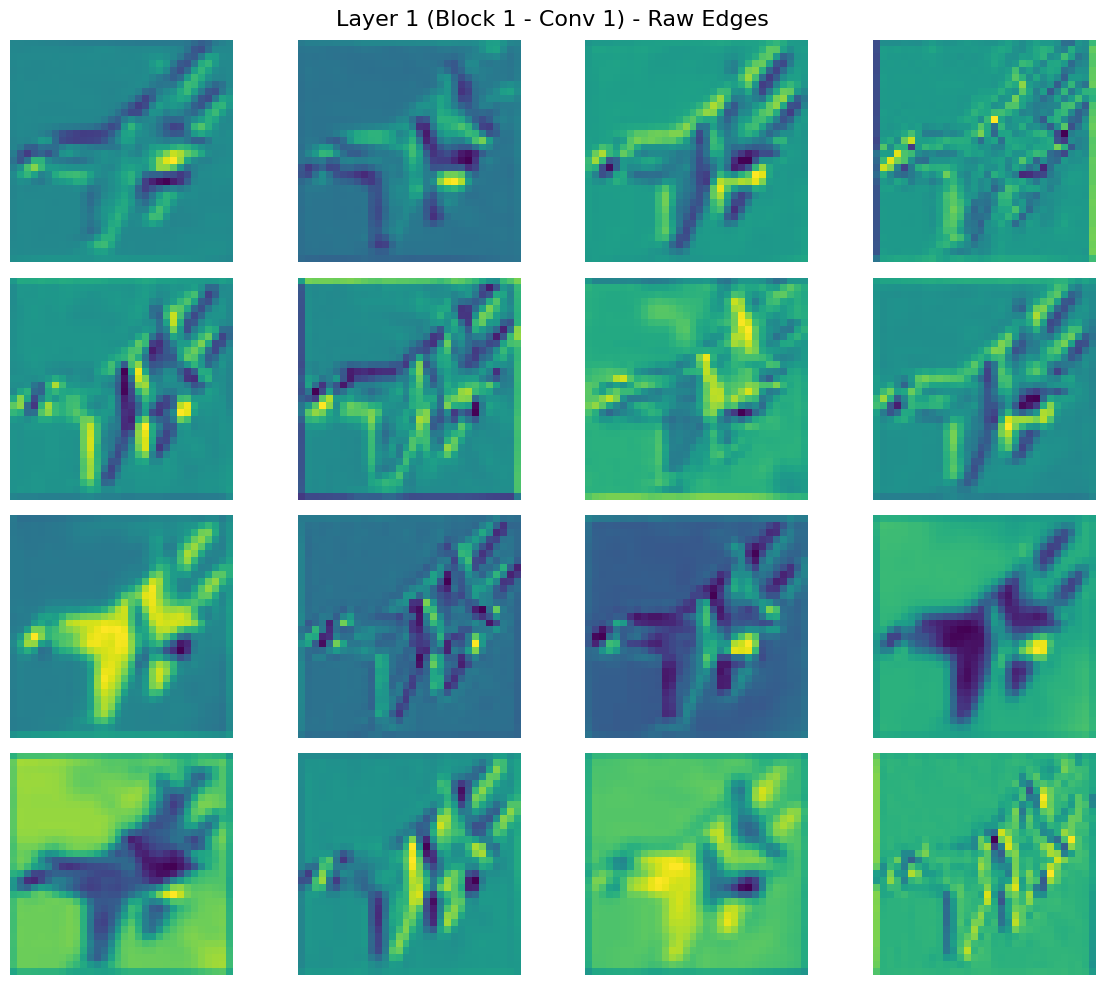

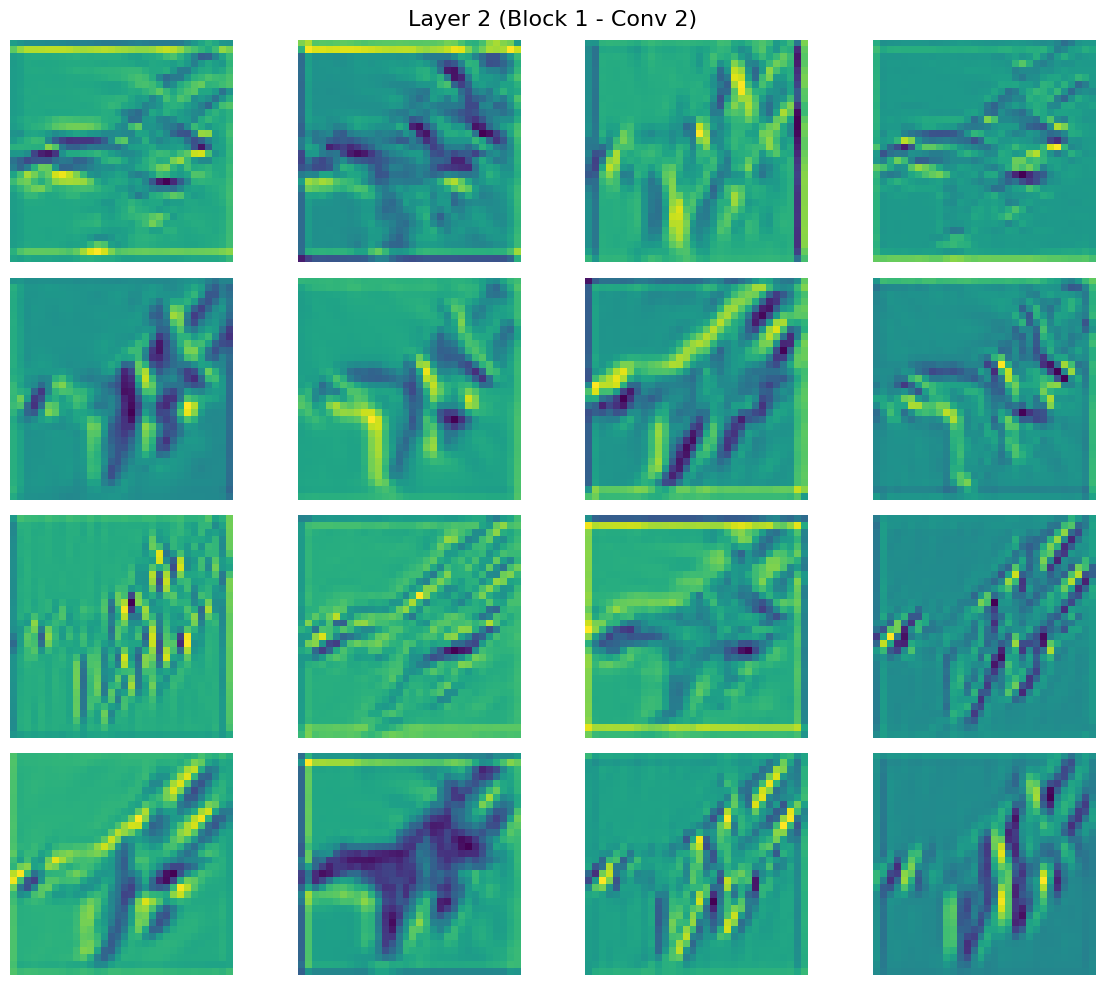

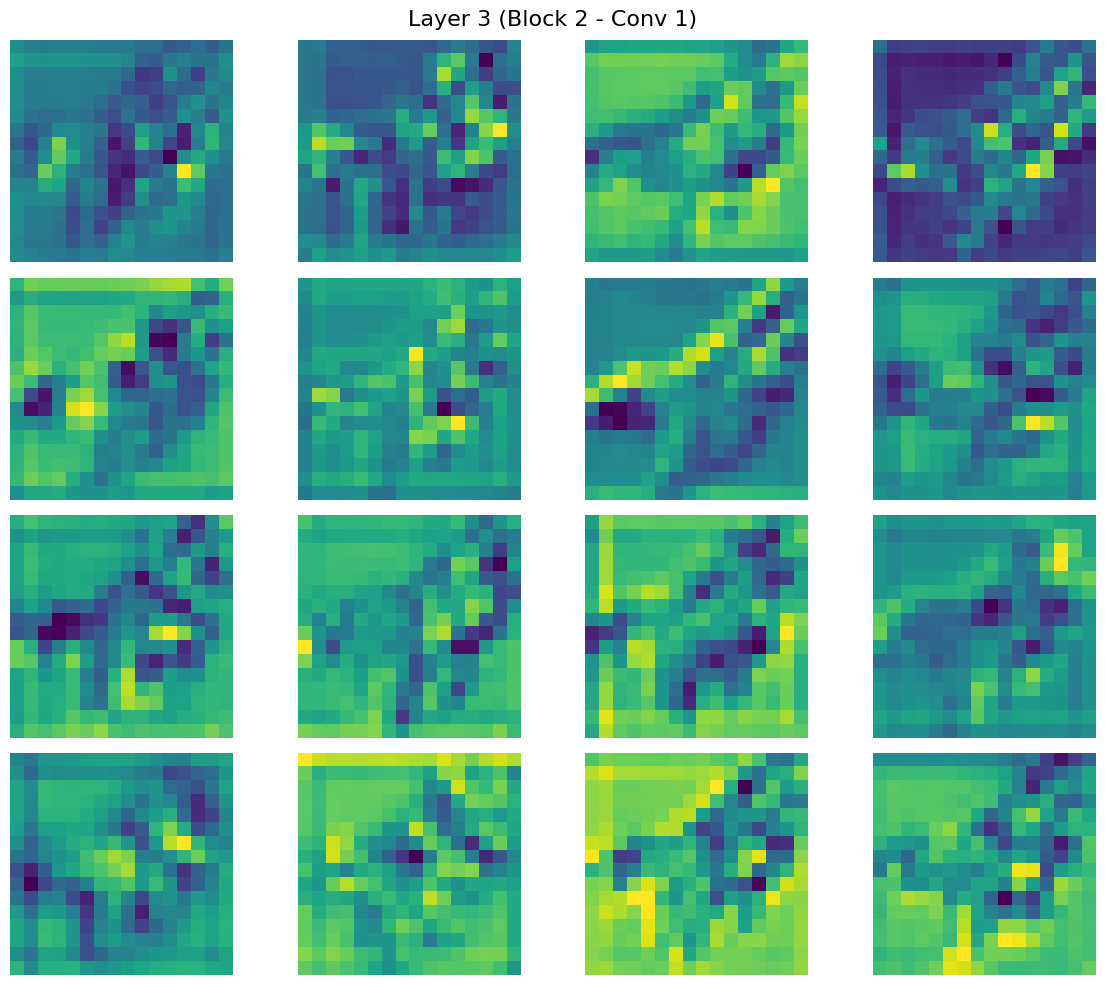

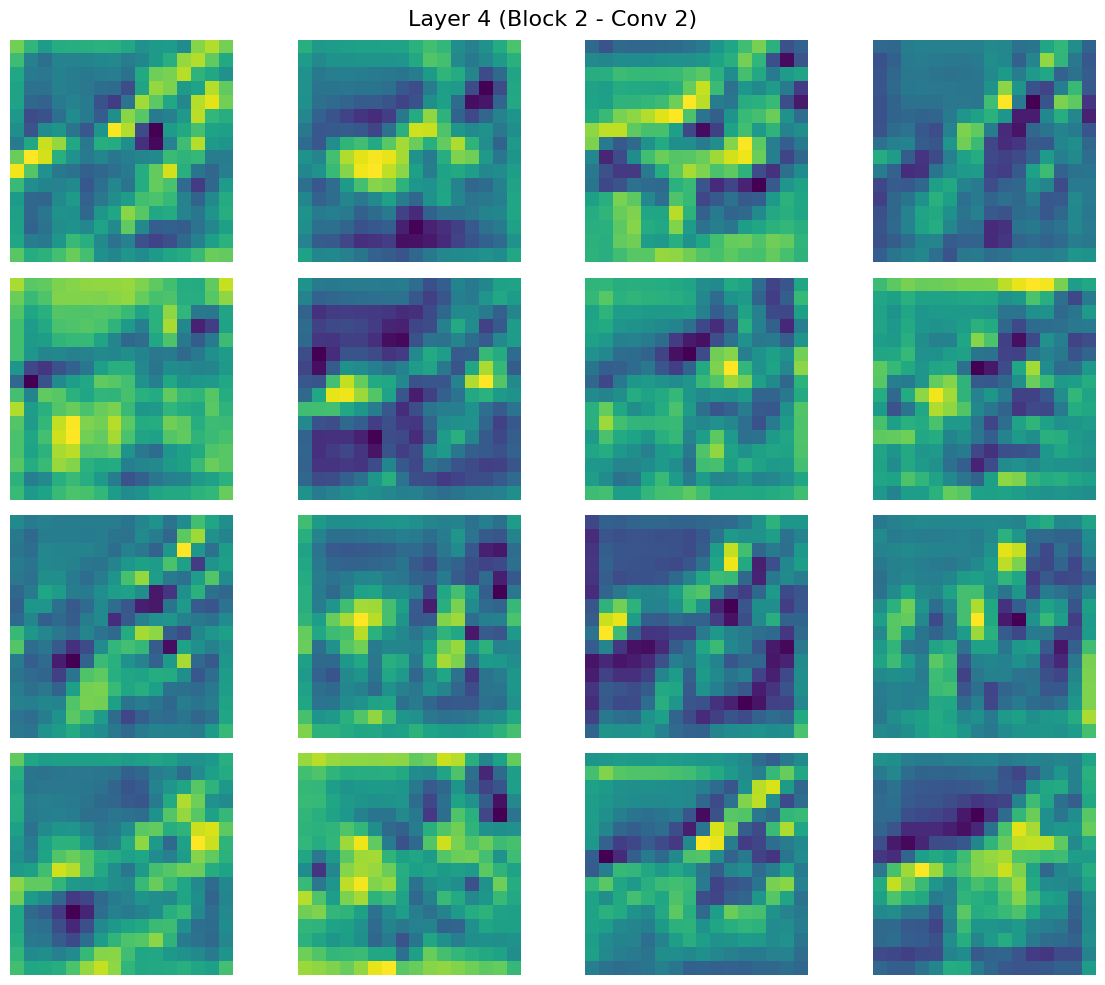

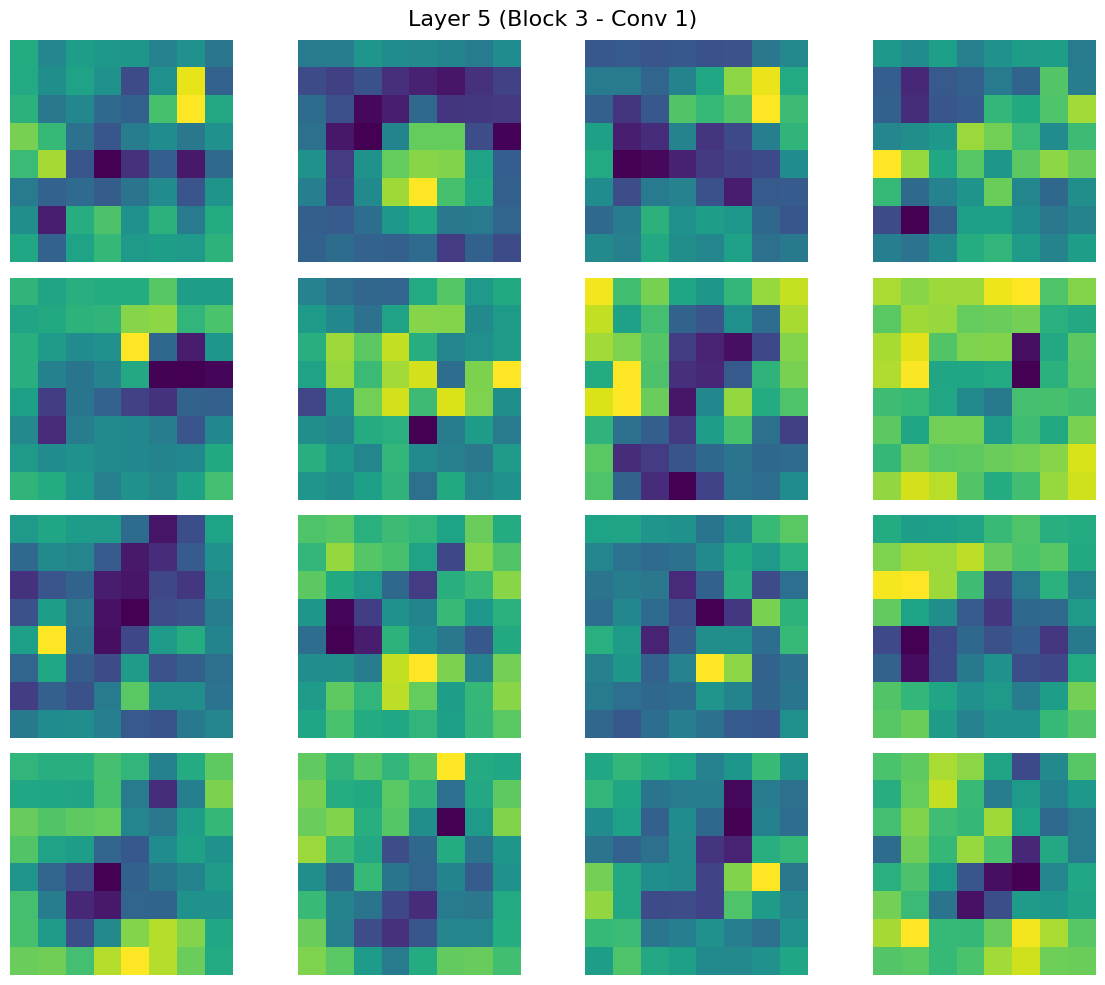

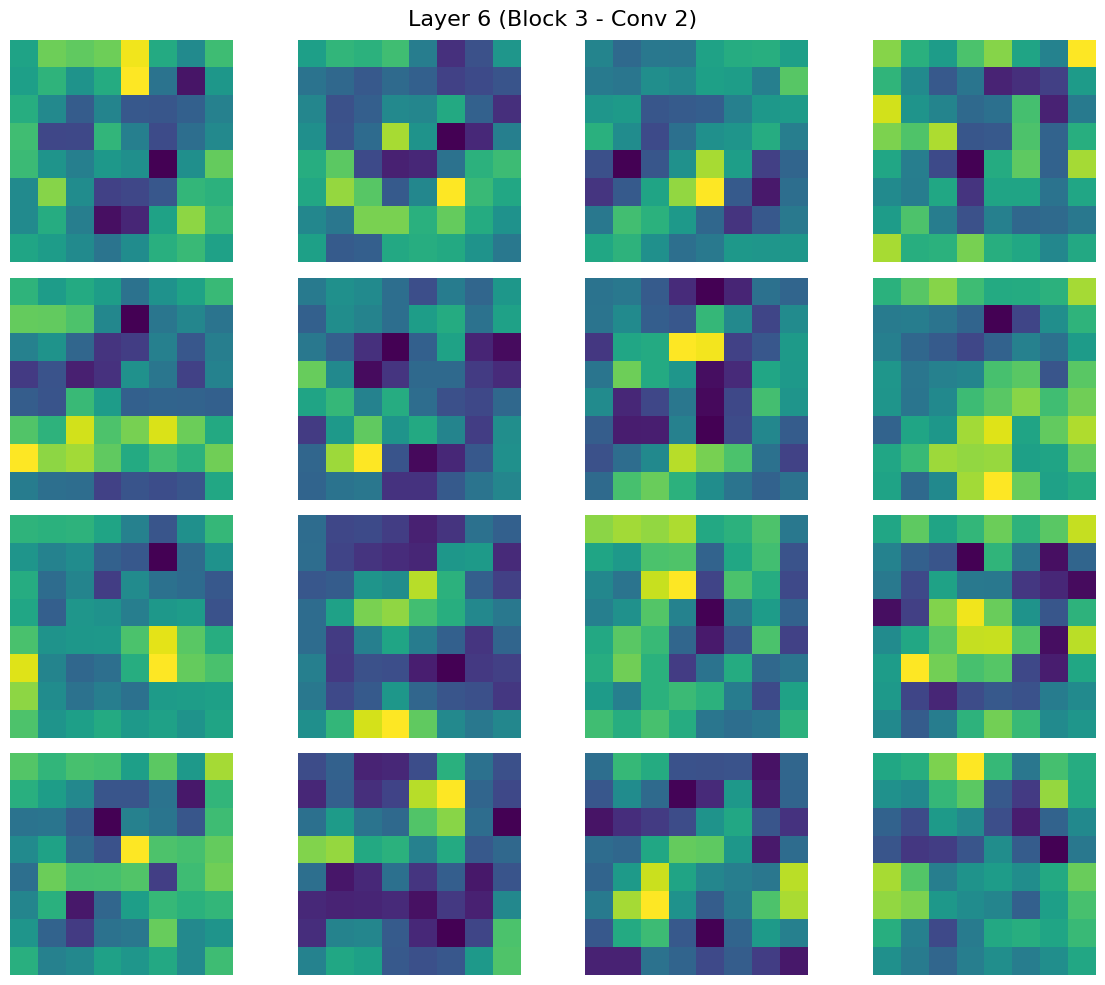

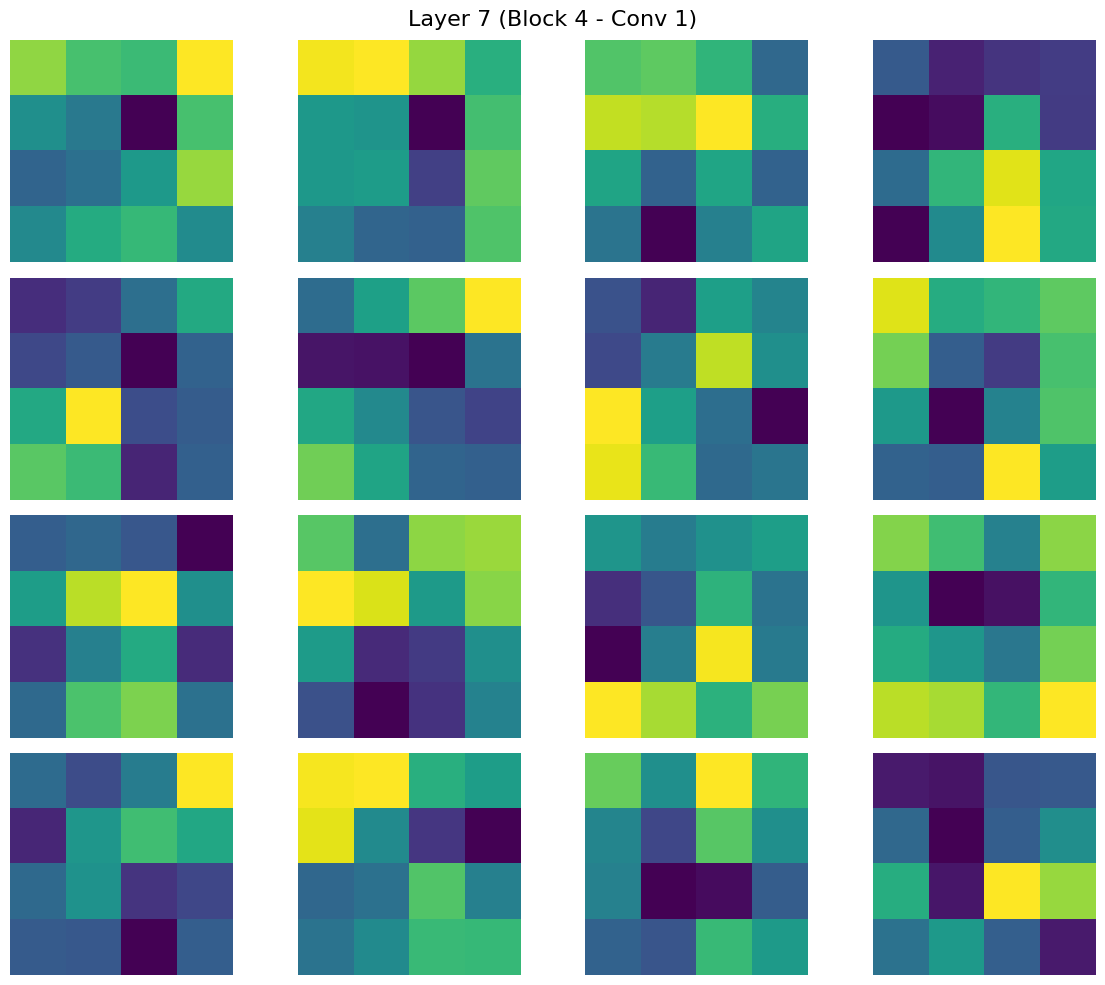

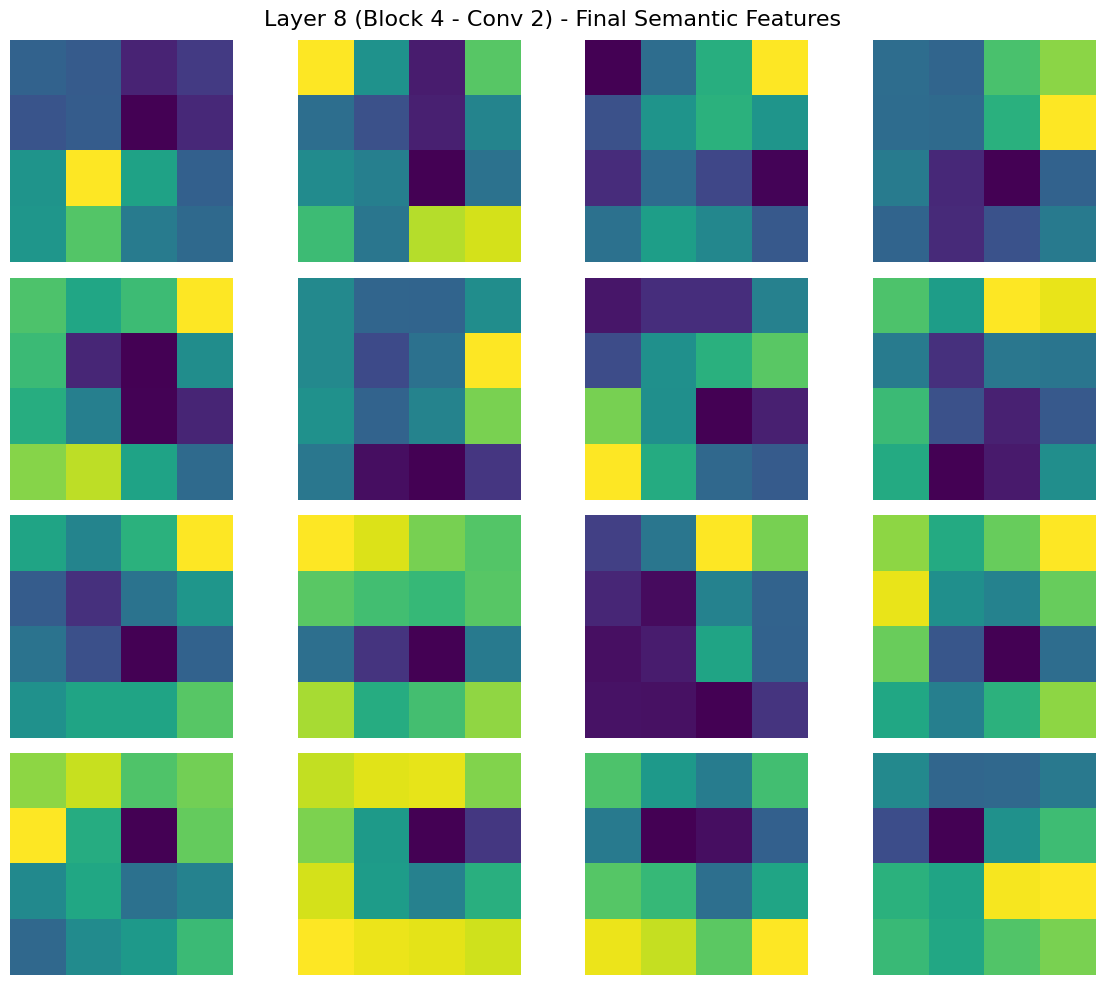

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

def unnormalize(tensor):
    tensor = tensor.cpu().clone()
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1)

def visualize_all_layers(model, loader, image_index=0):
    model.eval()

    # دریافت تصویر
    try:
        images, labels = next(iter(loader))
    except:
        loader_iter = iter(loader)
        images, labels = next(loader_iter)

    img_tensor = images[image_index].unsqueeze(0).to(device)

    # 1. نمایش ورودی
    plt.figure(figsize=(4, 4))
    original_img = unnormalize(images[image_index])
    plt.imshow(original_img.permute(1, 2, 0))
    try:
        class_name = full_train_dataset.classes[labels[image_index]]
    except:
        class_name = str(labels[image_index].item())
    plt.title(f"Input: {class_name}")
    plt.axis('off')
    plt.show()

    # 2. پیدا کردن تمام لایه‌های کانولوشنی (باید 8 تا باشند)
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))

    print(f"Found {len(conv_layers)} Convolutional Layers in the model.")

    # 3. هوک کردن به تک‌تک لایه‌های Conv2d
    activations = {}
    def get_activation(idx):
        def hook(model, input, output):
            activations[idx] = output.detach()
        return hook

    hooks = []
    for i, (name, module) in enumerate(conv_layers):
        hooks.append(module.register_forward_hook(get_activation(i)))

    # عبور تصویر
    with torch.no_grad():
        model(img_tensor)

    # حذف هوک‌ها
    for h in hooks:
        h.remove()

    # 4. رسم هر 8 لایه
    for i in range(len(conv_layers)):
        if i not in activations: continue

        act = activations[i].squeeze()
        num_channels = act.shape[0]

        # نمایش 16 کانال
        num_plots = min(16, num_channels)
        rows = num_plots // 4 + (1 if num_plots % 4 != 0 else 0)

        fig, axes = plt.subplots(rows, 4, figsize=(12, rows * 2.5))

        # نام‌گذاری دقیق (لایه چندم از کدام بلوک)
        block_num = (i // 2) + 1  # چون هر بلوک 2 لایه دارد
        sub_layer = (i % 2) + 1

        title = f"Layer {i+1} (Block {block_num} - Conv {sub_layer})"
        if i == 0: title += " - Raw Edges"
        if i == 7: title += " - Final Semantic Features"

        fig.suptitle(title, fontsize=16)

        if isinstance(axes, np.ndarray): axes = axes.flatten()
        else: axes = [axes]

        for j in range(len(axes)):
            if j < num_plots:
                axes[j].imshow(act[j].cpu().numpy(), cmap='viridis')
                axes[j].axis('off')
            else:
                axes[j].axis('off')

        plt.tight_layout()
        plt.savefig(f'outputs/figures/All_Layers_{i+1}.png')
        plt.show()

# اجرا روی یک تصویر
visualize_all_layers(model, val_loader, image_index=10)